In [1]:
import pandas as pd
path = "../data/processed/Food_Delivery_Times_Cleaned.csv"
df = pd.read_csv(path)
df.head(), df.shape


(   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
 0       522         7.93   Windy           Low   Afternoon      Scooter   
 1       738        16.42   Clear        Medium     Evening         Bike   
 2       741         9.52   Foggy           Low       Night      Scooter   
 3       661         7.44   Rainy        Medium   Afternoon      Scooter   
 4       412        19.03   Clear           Low     Morning         Bike   
 
    Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
 0                    12                     1.0               43.0  
 1                    20                     2.0               84.0  
 2                    28                     1.0               59.0  
 3                     5                     1.0               37.0  
 4                    16                     5.0               68.0  ,
 (1000, 9))

In [2]:
# Peak hours flag (you can tweak later)
df["Is_Peak"] = df["Time_of_Day"].isin(["Morning","Evening"]).astype(int)

# Prep efficiency = prep time adjusted by experience (add 1 to avoid division by zero)
df["Prep_Efficiency"] = df["Preparation_Time_min"] / (df["Courier_Experience_yrs"] + 1)

# (optional)distance buckets – nice for inspection/slicing later
import pandas as pd
df["Distance_Bucket"] = pd.cut(
    df["Distance_km"], bins=[0,5,10,20], labels=["Short","Medium","Long"], include_lowest=True
)

df.head()


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Is_Peak,Prep_Efficiency,Distance_Bucket
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43.0,0,6.000000,Medium
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84.0,1,6.666667,Long
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59.0,0,14.000000,Medium
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37.0,0,2.500000,Medium
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68.0,1,2.666667,Long


In [3]:
from sklearn.model_selection import train_test_split

target = "Delivery_Time_min"
features = [
    "Distance_km",
    "Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type",
    "Preparation_Time_min", "Courier_Experience_yrs",
    "Is_Peak", "Prep_Efficiency"
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

len(X_train), len(X_test)


(800, 200)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

cat_cols = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
num_cols = ["Distance_km", "Preparation_Time_min", "Courier_Experience_yrs", "Is_Peak", "Prep_Efficiency"]

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([("pre", pre), ("rf", rf)])

pipe.fit(X_train, y_train)


,steps,"[('pre', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
import numpy as np

pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
medae = median_absolute_error(y_test, pred)

# P90 absolute error (90th percentile of |y - yhat|)
abs_err = np.abs(y_test - pred)
p90 = np.percentile(abs_err, 90)

print(f"MAE: {mae:.2f} min")
print(f"MedianAE: {medae:.2f} min")
print(f"P90 error: {p90:.2f} min")


MAE: 6.69 min
MedianAE: 4.85 min
P90 error: 14.03 min


In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Reuse the same features and target from above
scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
mae_scores = -scores  # convert from negative to positive
print("MAE per fold:", np.round(mae_scores, 2))
print("Average MAE:", mae_scores.mean().round(2), "±", mae_scores.std().round(2))


MAE per fold: [8.18 7.39 7.48 7.67 7.06]
Average MAE: 7.56 ± 0.37


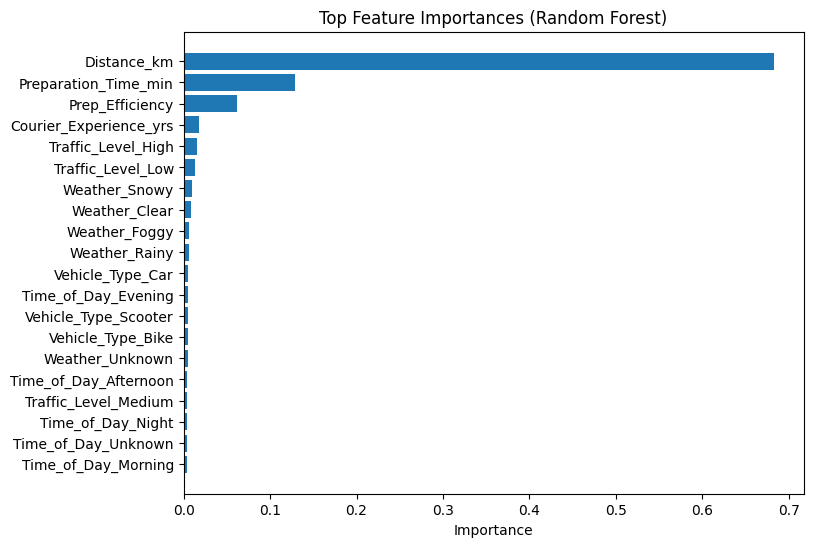

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# names produced by the preprocessor
ohe_names = pipe.named_steps["pre"].transformers_[1][1].get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_names)

importances = pipe.named_steps["rf"].feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx][:20], importances[idx][:20])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [7]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "rf__n_estimators": [200, 300, 400, 600],
    "rf__max_depth": [None, 8, 12, 16, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
best = search.best_estimator_
pred2 = best.predict(X_test)

print("Best params:", search.best_params_)
print("MAE tuned:", mean_absolute_error(y_test, pred2))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'rf__n_estimators': 600, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}
MAE tuned: 6.66259689904568


In [8]:
import os, joblib
os.makedirs("../models", exist_ok=True)
joblib.dump(best if 'best' in globals() else pipe, "../models/eta_model_rf.pkl")
print("Saved model to ../models/eta_model_rf.pkl")


Saved model to ../models/eta_model_rf.pkl


In [12]:
import joblib
import pandas as pd

# Load the saved model (it includes preprocessing)
model = joblib.load("../models/eta_model_rf.pkl")

# Create a sample order to predict
sample = pd.DataFrame([{
    "Distance_km": 7.5,
    "Weather": "Rainy",
    "Traffic_Level": "High",
    "Time_of_Day": "Evening",
    "Vehicle_Type": "Scooter",
    "Preparation_Time_min": 18,
    "Courier_Experience_yrs": 2.0,
    "Is_Peak": 1,
    "Prep_Efficiency": 18 / (2.0 + 1)
}])

# Make prediction
predicted_time = model.predict(sample)[0]
print(f"Predicted ETA: {predicted_time:.1f} minutes")


Predicted ETA: 54.2 minutes
